# SIR model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from matplotlib import rcParams

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

rcParams['figure.figsize'] = (18, 6)
rcParams['figure.autolayout'] = True


## Define SIR model
The `MyEpidemic()` model defines both the states (`S`, `I` and `R`) along with their initial values and also the form of the transition rates between the states (`S->I` and `I->R`).  The final line instantiates the epidemic model defined in `prog`.

In [3]:
from gem import GEM

prog = """
beta ~ Gamma(2.0, 10.0)
gamma ~ Gamma(1.0, 10.0)

Epidemic MyEpidemic() {

    S = State(init=990)
    I = State(init=10)
    R = State(init=0)
    
    [S -> I] = beta * I / 1000.0
    [I -> R] = [gamma]  # Make gamma broadcast as a vector
}
epi ~ MyEpidemic()
"""

model = GEM(prog)

initial instance: <class 'gem.gemlang.tf_output.Number'>
initial instance: <class 'gem.gemlang.tf_output.Number'>
initial instance: <class 'gem.gemlang.tf_output.Number'>


### Display DAG
A DAG of stochastic nodes in `model`

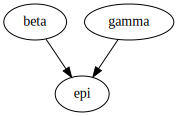

In [4]:
from gem.gemlang.dag import DAG

DAG(model.ast).dot()

## Simulation
The instantiated `model` can be used for the forward simulation of an epidemic.  In this instance the transition coeffients for `beta` and `gamma` are defined as constants e.g.`beta` is set to `0.3`.

In [5]:
sim = model.sample(1, condition_vars={'beta': 0.23, 'gamma': 0.05})

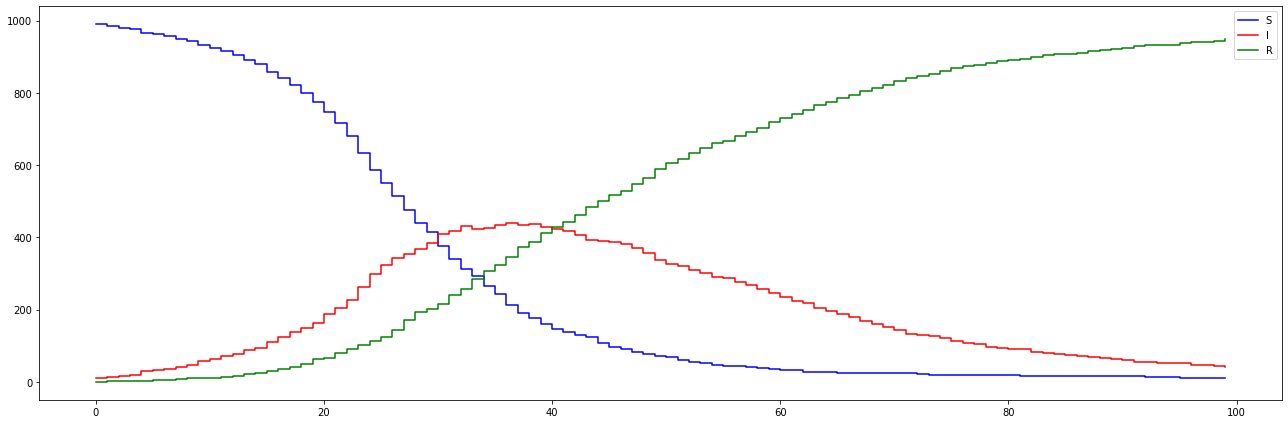

In [6]:
from gem.plotting import plot_state_timeseries

plot_state_timeseries(model['epi'], sim.epi, state_labels=("S", "I", "R"))

## Inference
Alternatively the instantiated `model` can be used for inference in which case the transition coeffients are estimated using their respective proiors. In this example the prior on `beta` is `Gamma(1,10)` as defined above in `prog`.

In [7]:
posterior, accept = model.fit(observed={'epi': sim.epi},
                              n_samples=10000, 
                              num_burnin_steps=5000, 
                              init={'beta': 0.001, 'gamma': 0.001})

Sampling...
Done in 6.934245948000353 seconds


In [8]:
a = accept.inner_results.is_accepted.numpy()

print('acceptance ratio:', sum(a)/a.size)

acceptance ratio: 0.8151


### Plot samples

The top row of plots relates to the `beta` estimates while the bottom row relates to `gamma`.


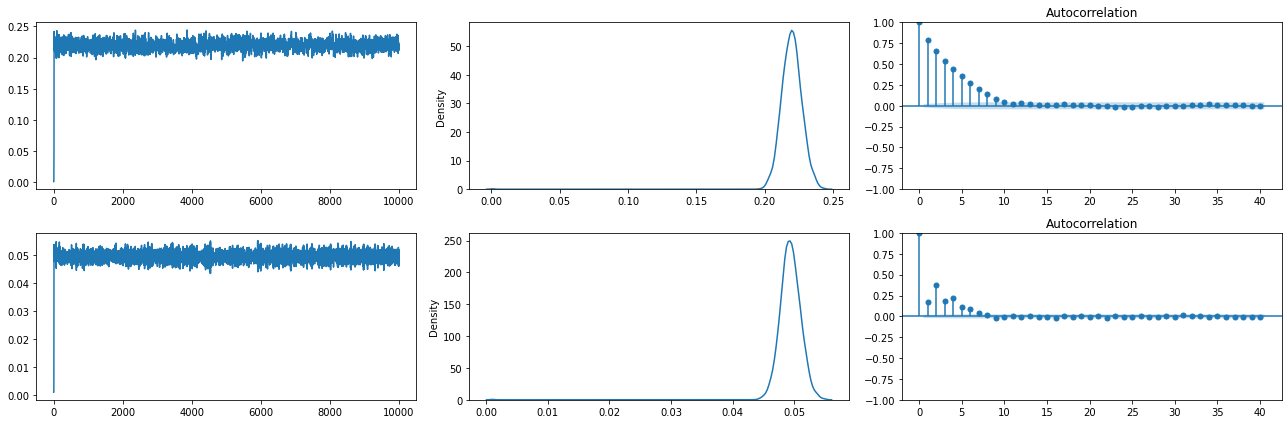

In [9]:
from gem.plotting import traceplot

_ = traceplot(posterior)